In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Loading

In [3]:
df = pd.read_csv('./train.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


# Data Cleaning + Outliers


In [4]:
df.isnull().sum()
# df = df.drop(['id'], axis=1)
df.shape

(750000, 18)

['default', 'balance', 'marital', 'day', 'poutcome', 'education', 'campaign', 'age', 'pdays', 'housing', 'contact', 'duration', 'previous', 'month', 'loan']


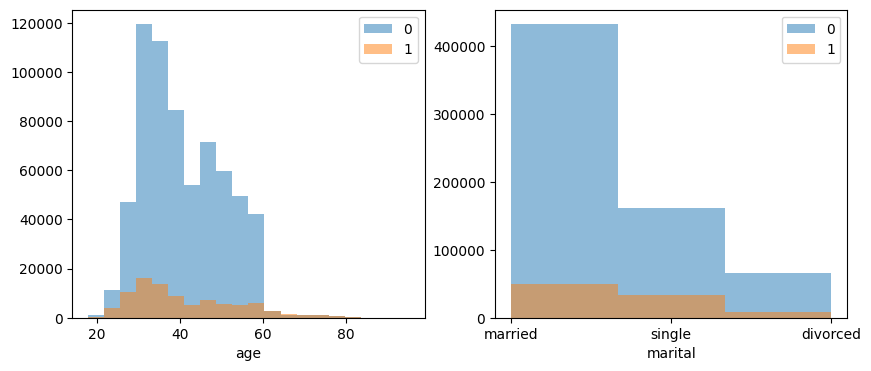

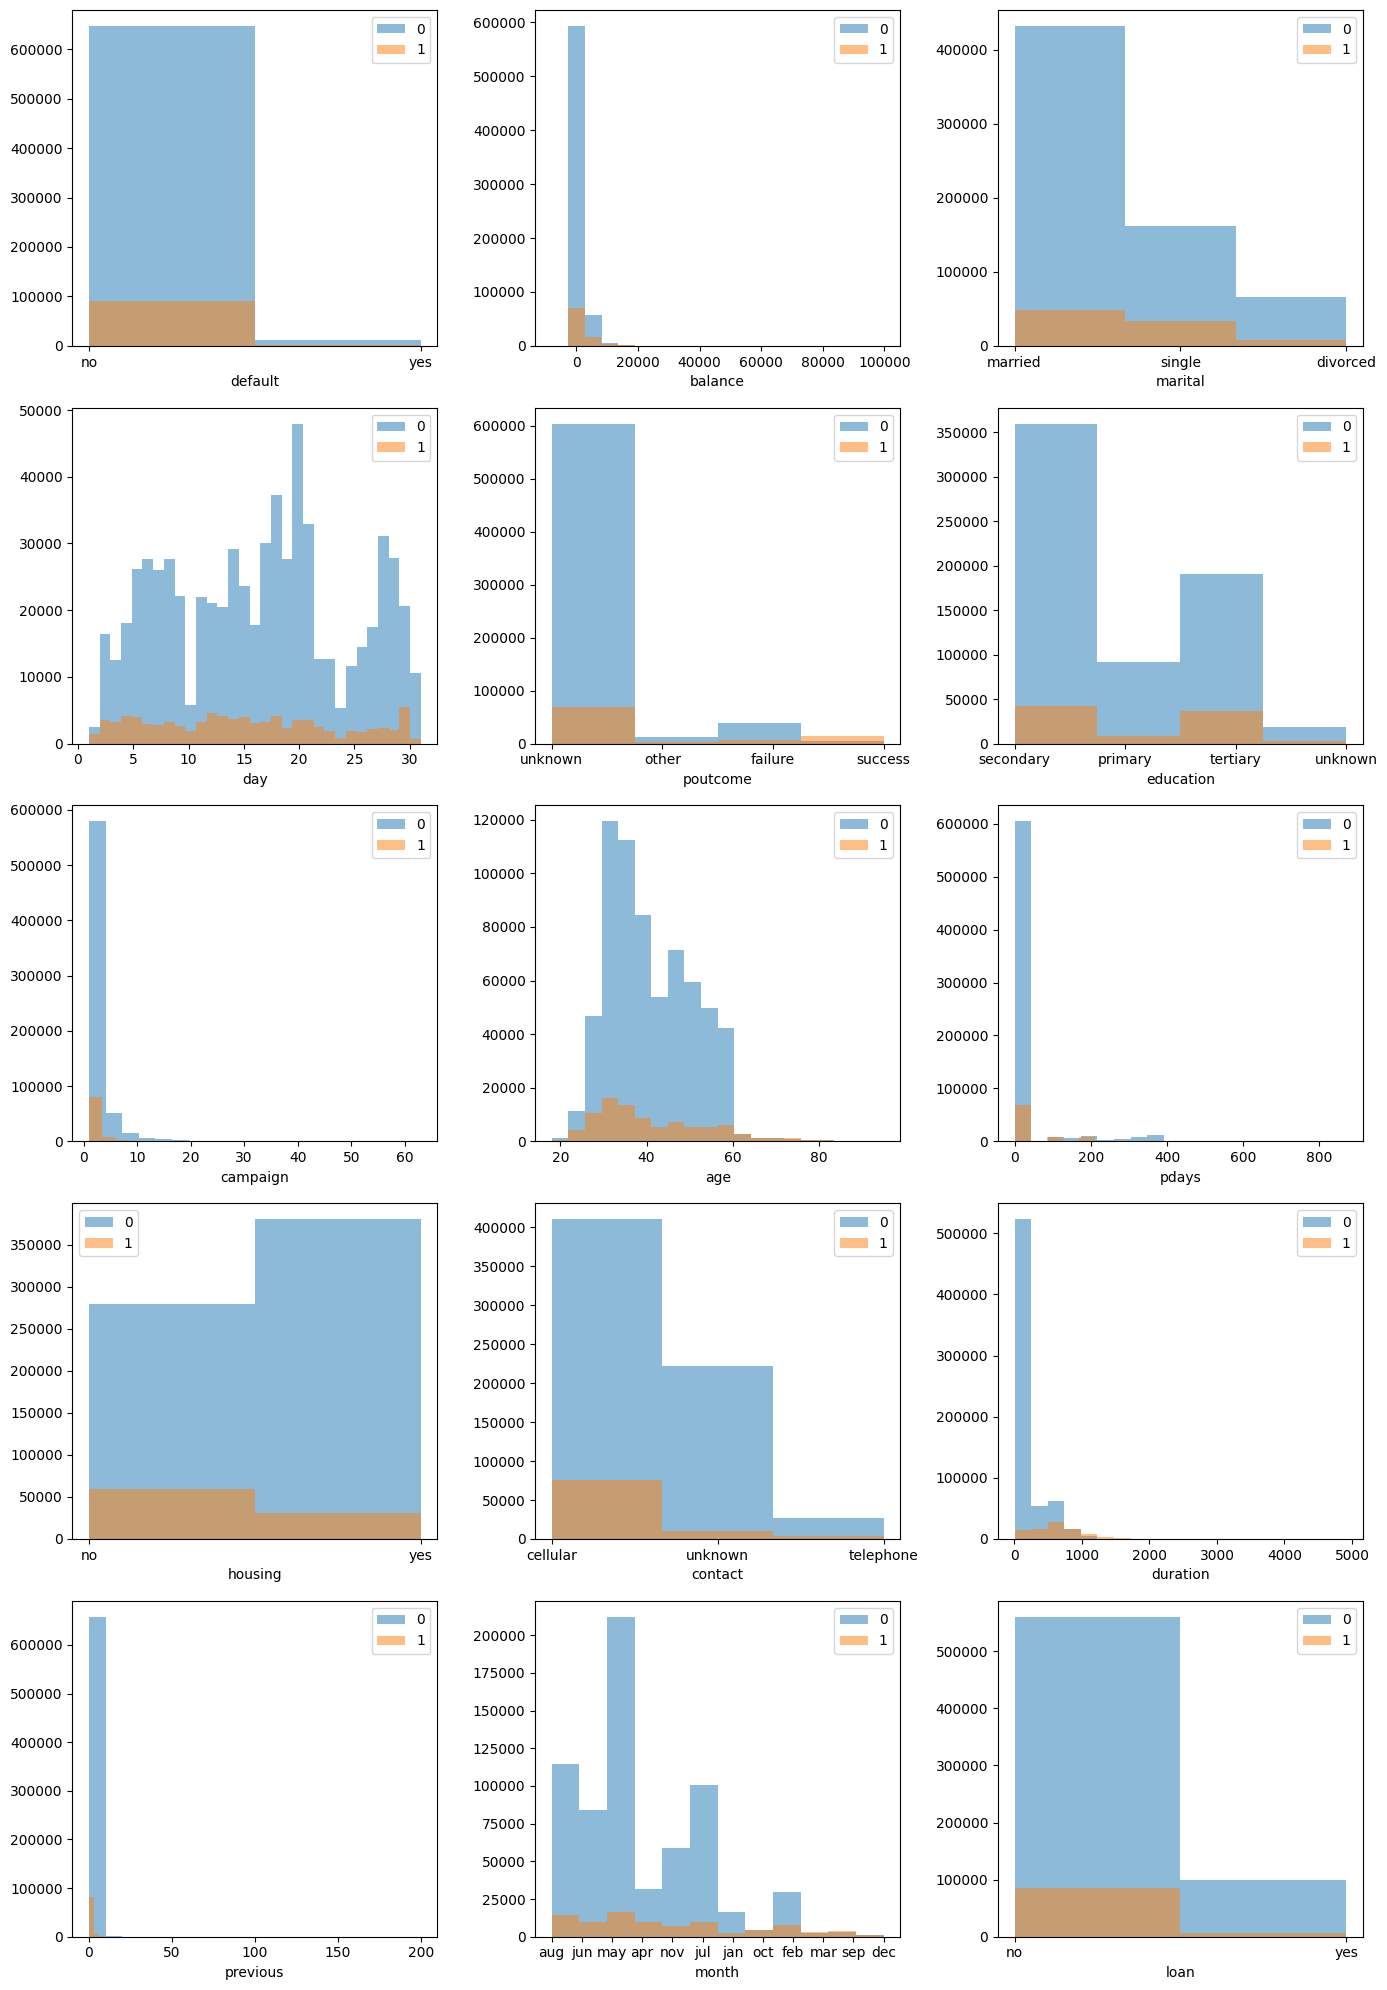

In [5]:
import matplotlib.pyplot as plt

categories = df['y'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

for cat in categories:
    subset_age = df[df['y'] == cat]['age']
    subset_marital = df[df['y'] == cat]['marital']
    ax1.hist(subset_age, bins=20, alpha=0.5, label=str(cat))
    ax2.hist(subset_marital, bins=3, alpha=0.5, label=str(cat))

ax1.set_xlabel('age')
ax1.legend()
ax2.set_xlabel('marital')
ax2.legend()

# loop through all features
# get the num of classes per feature and make that equal to the bin size in histogram

import matplotlib.pyplot as plt

# Features excluding target column
features = list(set(df.columns) - {'y', 'id', 'job'})
print(features)

categories = df['y'].unique()

# Number of subplots
num_cols = 3
num_rows = (len(features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
axes = axes.flatten()  # flatten so we can index easily

for idx, feature in enumerate(features):
    ax = axes[idx]

    # Decide bin count
    if feature in ['balance', 'age', 'duration', 'pdays', 'id', 'previous', 'campaign']:
        bins = 20
    else:
        bins = df[feature].nunique()

    for cat in categories:
        subset = df[df['y'] == cat][feature]
        ax.hist(subset, bins=bins, alpha=0.5, label=str(cat))

    ax.set_xlabel(feature)
    ax.legend()

# Hide any unused subplots
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




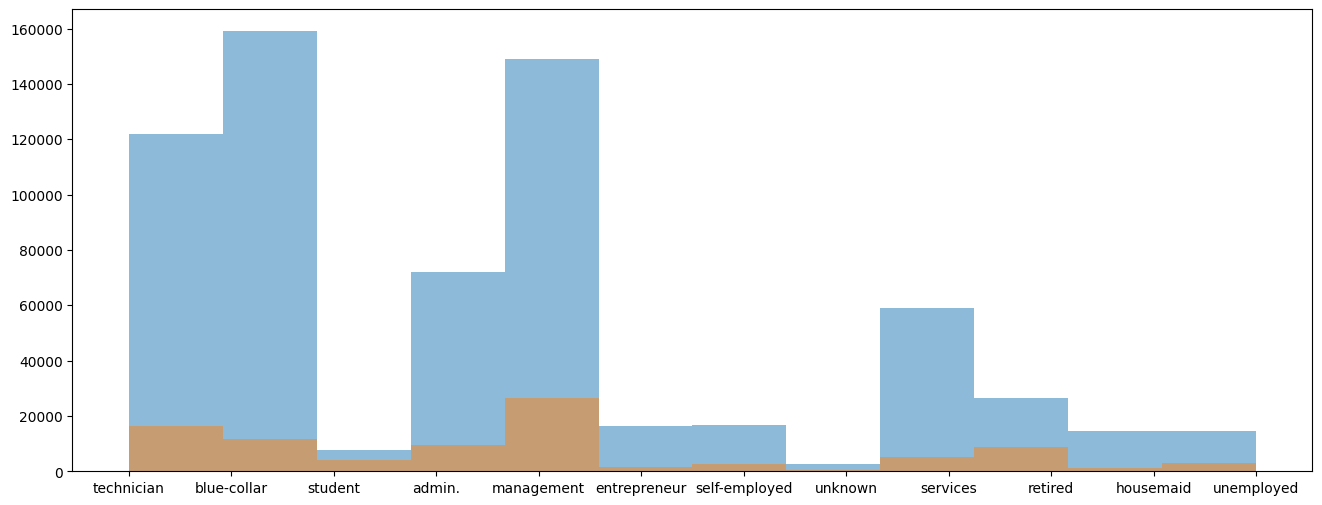

In [6]:

categories = df['y'].unique()
bins = df['job'].nunique()

fig, ax = plt.subplots(figsize=(16,6))

for c in categories:
    subset = df[df['y']==c]['job']
    ax.hist(subset, bins=bins, alpha=0.5, label=str(c))


In [7]:
# age range check, nothing sus
df['age'].min()
df['age'].max()

# check types of jobs and count, need to account for the unknowns somehow, for now drop?
df['job'].value_counts()
mask = (df['job'] == 'unknown')
# df.loc[mask, 'job'] = None
df = df[~mask]
df.shape

(747083, 18)

In [8]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()

# education check, unknowns present, maybe can infer job through education level later on?
def education_level(x):
    if str(x) == 'primary':
        return 1
    elif str(x) == 'secondary':
        return 2
    elif str(x) == 'tertiary':
        return 3
    return 0

df3 = df2.copy()
df3['education'] = df2['education'].apply(education_level)
# df3['education'].value_counts()

le = LabelEncoder()
columns_encode = ['default', 'housing', 'loan']

for col in columns_encode:
    df3[col] = le.fit_transform(df3[col])

df3.shape
#more

(747083, 18)

In [9]:

df4 = df3.copy()

print(df4.shape)
# student, can't be primary as a student
mask = ((df3['job'] == 'student') & (df4['education'].dropna().astype(int) <= 1))
# df4.loc[mask, 'education'] = None
df4 = df4[~mask]


# can't be retired and below 40 like what?
mask = (df4["job"] == "retired") & (df4["age"] < 60)
# df4.loc[mask, "job"] = None
df4 = df4[~mask]


# I mean if you are over 70 you are not doing labor or housemaid jobs anymore
# df4[(df4["age"] > 80)]['job'].value_counts()
mask = (df4['age'] > 80) & (~df4['job'].isin(['retired']))
# df4.loc[mask, "job"] = 'Retired'
df4 = df4[~mask]


# # older than 40, questionale student i think
mask = (df4['age'] > 30) & (df4['job'].isin(['student']))
# df4.loc[mask, 'job'] = None
df4 = df4[~mask]

 
# balance 0 or negative but signed up??? how
df[df['balance'] <= 0]['y'].value_counts()
mask = ((df4['balance'] <= 0) & (df['y']==1))
df4 = df4[~mask]


df4['previous'].unique()
#age, job, balance, marital duplicates?
# print(df4.shape)





(747083, 18)


C:\Users\bekim\AppData\Local\Temp\ipykernel_430320\1349515299.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = df4[~mask]


array([  0,   3,   2,   1,   4,   5,   6,  10,  11,   9,   7,  14,  13,
        17,   8,  24,  23,  37,  12,  27,  25,  38,  15,  16,  29,  19,
        20,  32,  55,  18,  34,  22,  26,  21,  35,  39,  28,  31,  43,
        30,  36,  33,  41,  51,  40,  47,  46, 200,  48,  58], dtype=int64)

# Feature Engineering


In [10]:

job_income_dict = {
    'admin.': 2,
    'blue-collar': 1,
    'entrepreneur': 2,
    'housemaid': 1,
    'management': 3,
    'retired': 3,
    'self-employed': 3,
    'services': 1,
    'student': 1,
    'technician': 3,
    'unemployed': 1
}

df4['income_level'] = df4['job'].map(job_income_dict)

categories = df4['y'].unique()
bins = df4['income_level'].nunique()

# fig, ax = plt.subplots(figsize=(16,6))

# for c in categories:
    
#     subset = df4[df4['y']==c]['income_level']
#     ax.hist(subset, bins=bins, alpha=0.5, label=str(c))

# ax.legend()

In [11]:
# 2 is married
df4['is_married'] = df4['marital'] == 'married'

# 3 highly educated
df4['is_highly_educated'] = df4['education'] == 3

# 4 average salar is normal for age an occupation, if not then remove?
df4['ageBin'] = pd.cut(
    df['age'],
    bins=[17, 28, 40, 50, 70, df['age'].max()],
    labels=['Young Adult', 'Adult', 'Older Adult', 'Senior', 'OAP'],
    right=True
)

# 5 contacted before?
df4['never_contacted_before'] = df4['pdays'] == -1

#combine some features
df4['married_young_adult'] = (df4['is_married']==True) & (df4['ageBin']=='Young Adult')
df4['single_adult_lowbalance'] = (df4['is_married']==False) & (df4['ageBin'].isin(['Young Adult', 'Adult'])) & (df4['balance'] < df4['balance'].mean())

df4['successb4_Adult_nohouse_married'] = (df4['is_married']==True) & (df4['ageBin'].isin(['Adult'])) & (df4['housing'] == 0) & (df['poutcome']=='success')



In [12]:
# todo scatter plot

def remove_balance_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df4.groupby(['ageBin', 'job']):
        m = np.mean(subdf.balance)
        std = np.std(subdf.balance)
        reduced_df = subdf[(subdf.balance > (m-(std))) & (subdf.balance <= (m+(std)))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    
    return df_out

print(df4.shape)
df5 = remove_balance_outliers(df4)  

df5 = df5.dropna()
df5.shape


(716676, 26)


C:\Users\bekim\AppData\Local\Temp\ipykernel_430320\2418628610.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for key, subdf in df4.groupby(['ageBin', 'job']):


(667205, 26)

# Preprocessing

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


categorical_columns = df5.select_dtypes(['object', 'bool', 'category']).columns.to_list()
numerical_columns = df5.select_dtypes('int64').columns.to_list()
numerical_columns = list(set(numerical_columns)-set(['y']))


cat_transformer = Pipeline(steps=[
    # ('impute', SimpleImputer(strategy='most_frequent')),
    ('oneHot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, categorical_columns),
    ('num', num_transformer, numerical_columns)
])


X = df5[numerical_columns + categorical_columns]
y = df5['y']


In [14]:
# from sklearn.decomposition import PCA

# X_num = numerical_columns

# pca = PCA()
# pca.fit(StandardScaler().fit_transform(X_num))

# Model Building


In [15]:
# base model

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=21)

bank_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMClassifier())
])

bank_pipeline.fit(train_X, train_y)
y_pred_single = bank_pipeline.predict(val_X)

accuracy_score_single = accuracy_score(val_y, y_pred_single)
print(round(accuracy_score_single, 3))

[LightGBM] [Info] Number of positive: 55397, number of negative: 478367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 533764, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103786 -> initscore=-2.155853
[LightGBM] [Info] Start training from score -2.155853
0.941


In [16]:
# # stacked model
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from lightgbm import LGBMClassifier
# from scipy.stats import randint, uniform, loguniform
# from xgboost import XGBClassifier
# from sklearn.svm import LinearSVC

# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=21)

# model_dict = {
#     # 'lgr': {
#     #     'model': LogisticRegression(solver='liblinear'),
#     #     'params': {
#     #         'model__C': uniform(0.01, 10),        # regularization strength
#     #         'model__penalty': ['l1', 'l2']        # logistic regression penalties
#     #     }
#     # },
#     'lgbm': {
#         'model': LGBMClassifier(),
#         'params': {
#             'model__n_estimators': randint(50, 500),       # number of trees
#             'model__max_depth': randint(3, 15),            # tree depth
#             'model__learning_rate': uniform(0.01, 0.3),    # shrinkage rate
#         }
#     }
#     # 'svc': {
#     #     'model': LinearSVC(),
#     #     'params': {
#     #         'model__C': loguniform(1e-3, 1e3),   # wide range for C
#     #     }
#     # }
# }


# def model_tuning(preprocessor, train_X, val_X, train_y, val_y, model_dict):
#     estimators = []
#     for key, val in model_dict.items():
#         model_abr = key
#         model_type = val['model']
#         params = val['params']


#         bank_pipeline = Pipeline(steps=[
#             ('preprocess', preprocessor),
#             ('model', model_type)
#         ])

#         grid = RandomizedSearchCV(
#             bank_pipeline,
#             params,
#             scoring='accuracy',
#             n_iter=30,
#             cv=3,
#             n_jobs=-1,
#             verbose=1,
#         )

#         grid.fit(train_X, train_y)
#         best_params = grid.best_params_
#         model_params = {key.replace('model__', ''): val for key, val in best_params.items()}
#         tuned_model = type(model_type)(**model_params)

#         estimators.append((model_abr, tuned_model))
    
#     return estimators

# estimators = model_tuning(preprocessor, train_X, val_X, train_y, val_y, model_dict)

In [17]:
# from sklearn.ensemble import StackingClassifier

# bank_stack_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     verbose=1,
#     n_jobs=-1
# )

# bank_pipeline_stack = Pipeline(steps=[
#     ('preprocess', preprocessor),
#     ('model', bank_stack_model)
# ])

# bank_pipeline_stack.fit(train_X, train_y)
# y_pred_stack = bank_pipeline_stack.predict(val_X)

# accuracy_score_stacking = accuracy_score(val_y, y_pred_stack)

In [18]:
print(accuracy_score_single)
# print(accuracy_score_stacking)

0.9409551786932052


# Model Evaluation

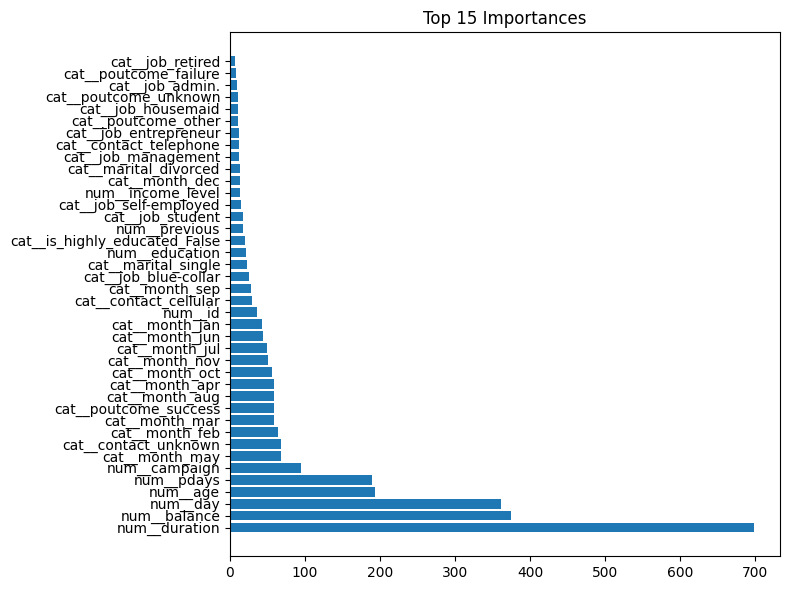

In [19]:
import matplotlib.pyplot as plt

preprocessor = bank_pipeline.named_steps['preprocess']
model = bank_pipeline.named_steps['model']

features = preprocessor.get_feature_names_out()
importances = model.feature_importances_

importance_df = pd.DataFrame(
    {
        'feature': features,
        'importance': model.feature_importances_
    }
).sort_values(by='importance', ascending=False).head(40)

plt.figure(figsize=(8,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title("Top 15 Importances")
plt.tight_layout()
plt.show()


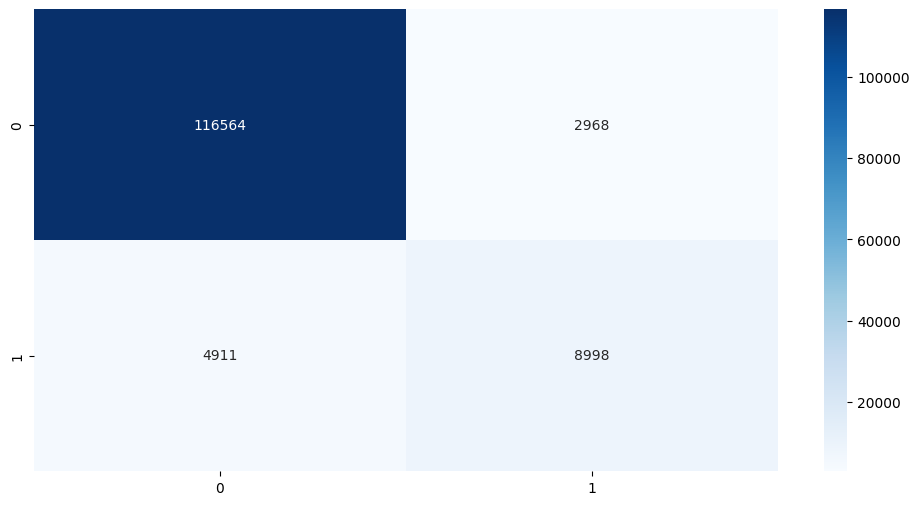

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    119532
           1       0.75      0.65      0.70     13909

    accuracy                           0.94    133441
   macro avg       0.86      0.81      0.83    133441
weighted avg       0.94      0.94      0.94    133441



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_labels = df['y'].unique()

cr = classification_report(val_y, y_pred_single)
cm = confusion_matrix(val_y, y_pred_single)

plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.show()

print(cr)

# Model Submission

In [ ]:
df_test = pd.read_csv('./test.csv')

mask = (df_test['job'] == 'unknown')
# df_test.loc[mask, 'job'] = None
df_test = df_test[~mask]

def education_level(x):
    if str(x) == 'primary':
        return 1
    elif str(x) == 'secondary':
        return 2
    elif str(x) == 'tertiary':
        return 3
    return 0

df_test = df_test.copy()
df_test['education'] = df_test['education'].apply(education_level)

le = LabelEncoder()
columns_encode = ['default', 'housing', 'loan']

for col in columns_encode:
    df_test[col] = le.fit_transform(df_test[col])

mask = ((df_test['job'] == 'student') & (df_test['education'].dropna().astype(int) <= 1))
# df_test.loc[mask, 'education'] = None
df_test = df_test[~mask]


# can't be retired and below 40 like what?
mask = (df_test["job"] == "retired") & (df_test["age"] < 60)
# df_test.loc[mask, "job"] = None
df_test = df_test[~mask]


# I mean if you are over 70 you are not doing labor or housemaid jobs anymore
df_test[(df_test["age"] > 80)]['job'].value_counts()
mask = (df_test['age'] > 80) & (~df_test['job'].isin(['retired']))
# df_test.loc[mask, "job"] = 'Retired'
df_test = df_test[~mask]


# # older than 40, questionale student i think
mask = (df_test['age'] > 30) & (df_test['job'].isin(['student']))
# df_test.loc[mask, 'job'] = None
df_test = df_test[~mask]


job_income_dict = {
    'admin.': 2,
    'blue-collar': 1,
    'entrepreneur': 2,
    'housemaid': 1,
    'management': 3,
    'retired': 3,
    'self-employed': 3,
    'services': 1,
    'student': 1,
    'technician': 3,
    'unemployed': 1
}

df_test['income_level'] = df_test['job'].map(job_income_dict)

# 2 is married
df_test['is_married'] = df_test['marital'] == 'married'

# 3 highly educated
df_test['is_highly_educated'] = df_test['education'] == 3

# 4 average salar is normal for age an occupation, if not then remove?
df_test['ageBin'] = pd.cut(
    df_test['age'],
    bins=[17, 28, 40, 50, 70, df['age'].max()],
    labels=['Young Adult', 'Adult', 'Older Adult', 'Senior', 'OAP'],
    right=True
)

# 5 contacted before?
df_test['never_contacted_before'] = df_test['pdays'] == -1

#combine some features
df_test['married_young_adult'] = (df_test['is_married']==True) & (df_test['ageBin']=='Young Adult')
df_test['single_adult_lowbalance'] = (df_test['is_married']==False) & (df_test['ageBin'].isin(['Young Adult', 'Adult'])) & (df_test['balance'] < df_test['balance'].mean())
df_test['successb4_Adult_nohouse_married'] = (df_test['is_married']==True) & (df_test['ageBin'].isin(['Adult'])) & (df_test['housing'] == 0) & (df_test['poutcome']=='success')

X_test = df_test[numerical_columns+categorical_columns]
pred = bank_pipeline.predict(X_test)

submission = pd.DataFrame({
    'id': df_test['id'],
    'y': pred.astype(int)
})

submission.to_csv('submission.csv', index=False)